In [1]:
from astropy import units as u
from matplotlib import pyplot as plt
from regions import CircleSkyRegion, EllipseSkyRegion, PolygonSkyRegion, RectangleSkyRegion, Regions
from astropy.coordinates import SkyCoord
from astropy import units as u
from m4opt.fov import footprint
from m4opt import skygrid

import numpy as np
import pandas as pd
import ligo.skymap.plot
import numpy as np

/Users/vedshah/anaconda3/envs/ls4-fields/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:35: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/Users/vedshah/anaconda3/envs/ls4-fields/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


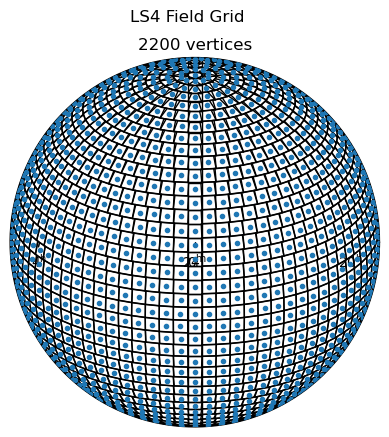

In [2]:
FOV = 20*u.deg**2


n_vertices_target = 1024
vertices = skygrid.sinusoidal(FOV)
n_vertices = len(vertices)

region2 = RectangleSkyRegion(SkyCoord(0 * u.deg, 0 * u.deg), FOV**0.5, FOV**0.5)
target_coord = vertices
footprints = footprint(region2, target_coord)

ax = plt.axes(projection='astro globe', center='0d 25d')
plt.suptitle('LS4 Field Grid')
ax.set_title(f'{n_vertices} vertices')
ax.plot_coord(vertices, '.')
#ax.grid()

for region in footprints:
    ax.add_patch(region.to_pixel(ax.wcs).as_artist())
plt.show()

In [5]:
ra_deg = vertices.ra.to(u.deg).value
dec_deg = vertices.dec.to(u.deg).value
df = pd.DataFrame({"ra_deg": ra_deg, "dec_deg": dec_deg})
df

,ra_deg,dec_deg
0,0.0,-90.000000
1,0.0,-85.609756
2,36.0,-85.609756
3,72.0,-85.609756
4,108.0,-85.609756
...,...,...
2195,216.0,85.609756
2196,252.0,85.609756
2197,288.0,85.609756
2198,324.0,85.609756


In [7]:
df.to_csv('LS4_field_grid.csv', index=None)

In [10]:
# ...existing code...
import plotly.graph_objects as go

ra = vertices.ra.to(u.rad).value
dec = vertices.dec.to(u.rad).value
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)

fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode="markers",
    marker=dict(size=2, color=ra, colorscale="Viridis")
))
fig.update_layout(
    title="LS4 Field Grid (interactive sphere)",
    width=900,
    height=700,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False))
)
fig.show()
# ...existing code...

In [11]:
# ...existing code...
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode="markers",
    marker=dict(size=2, color=ra, colorscale="Viridis"),
    name="Grid vertices"
))

pointing = vertices[0]
side = np.sqrt(FOV.to(u.deg**2)).to(u.deg)
half_w = half_h = 0.5 * side

corner_offsets = [
    (-half_w, -half_h),
    (half_w, -half_h),
    (half_w, half_h),
    (-half_w, half_h),
    (-half_w, -half_h)
]

corner_coords = SkyCoord([pointing.spherical_offsets_by(dlon, dlat)
                          for dlon, dlat in corner_offsets])

corner_ra = corner_coords.ra.to(u.rad).value
corner_dec = corner_coords.dec.to(u.rad).value
fov_x = np.cos(corner_dec) * np.cos(corner_ra)
fov_y = np.cos(corner_dec) * np.sin(corner_ra)
fov_z = np.sin(corner_dec)

center_ra = pointing.ra.to(u.rad).value
center_dec = pointing.dec.to(u.rad).value
center_x = np.cos(center_dec) * np.cos(center_ra)
center_y = np.cos(center_dec) * np.sin(center_ra)
center_z = np.sin(center_dec)

fig.add_trace(go.Scatter3d(
    x=[center_x], y=[center_y], z=[center_z],
    mode="markers",
    marker=dict(size=6, color="red"),
    name="Selected pointing"
))
fig.add_trace(go.Scatter3d(
    x=fov_x, y=fov_y, z=fov_z,
    mode="lines",
    line=dict(color="red", width=6),
    name="FoV outline"
))

fig.update_layout(
    title="LS4 Field Grid (interactive sphere)",
    width=1100,
    height=900,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False))
)
fig.show()
# ...existing code...

In [12]:
# ...existing code...
import plotly.graph_objects as go

def footprint_outline(region):
    if hasattr(region, "to_polygon_sky"):
        vertices = region.to_polygon_sky().vertices
    elif hasattr(region, "vertices"):
        vertices = region.vertices
    else:
        return None, None
    lon = vertices.ra.wrap_at(180 * u.deg).deg
    lat = vertices.dec.deg
    lon = np.append(lon, lon[0])
    lat = np.append(lat, lat[0])
    return lon, lat

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=vertices.ra.wrap_at(180 * u.deg).deg,
    lat=vertices.dec.deg,
    mode="markers",
    marker=dict(size=4, color="royalblue"),
    name="Grid vertices"
))

for i, region in enumerate(footprints):
    lon, lat = footprint_outline(region)
    if lon is None:
        continue
    fig.add_trace(go.Scattergeo(
        lon=lon,
        lat=lat,
        mode="lines",
        line=dict(width=1.5, color="firebrick"),
        name="FoV footprint" if i == 0 else None,
        showlegend=(i == 0)
    ))

fig.update_layout(
    title="LS4 Field Grid (interactive)",
    height=750,
    geo=dict(
        projection_type="orthographic",
        projection_rotation=dict(lon=0, lat=25),
        showland=False,
        showcountries=False,
        showcoastlines=False,
        lonaxis=dict(showgrid=True, gridwidth=0.5),
        lataxis=dict(showgrid=True, gridwidth=0.5)
    )
)
fig.show()
# ...existing code...

In [24]:
# ...existing code...
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode="markers",
    marker=dict(size=3, color=ra, colorscale="Viridis"),
    name="Grid vertices"
))

side = np.sqrt(FOV.to(u.deg**2)).to(u.deg)
half_w = half_h = 0.5 * side
quadrants = [
    ("I band", -half_w, 0 * half_w, 0 * half_h, half_h, "rgba(204,119,34,0.3)", "I"),
    ("I band", 0 * half_w, half_w, 0 * half_h, half_h, "rgba(204,119,34,0.3)", "I"),
    ("g band", -half_w, 0 * half_w, -half_h, 0 * half_h, "rgba(113,188,120,0.3)", "g"),
    ("z band", 0 * half_w, half_w, -half_h, 0 * half_h, "rgba(128,0,0,0.3)", "z"),
]

legend_flags = {"I": False, "g": False, "z": False}
selected_indices = [0, 5, 12]  # choose any vertex indices you want to display

for idx in selected_indices:
    pointing = vertices[idx]
    for name, lon_lo, lon_hi, lat_lo, lat_hi, color, key in quadrants:
        offsets = [
            (lon_lo, lat_lo),
            (lon_hi, lat_lo),
            (lon_hi, lat_hi),
            (lon_lo, lat_hi),
        ]
        corner_coords = SkyCoord([pointing.spherical_offsets_by(dlon, dlat)
                                  for dlon, dlat in offsets])
        corner_ra = corner_coords.ra.to(u.rad).value
        corner_dec = corner_coords.dec.to(u.rad).value
        quad_x = np.cos(corner_dec) * np.cos(corner_ra)
        quad_y = np.cos(corner_dec) * np.sin(corner_ra)
        quad_z = np.sin(corner_dec)

        fig.add_trace(go.Mesh3d(
            x=quad_x,
            y=quad_y,
            z=quad_z,
            i=[0, 0],
            j=[1, 2],
            k=[2, 3],
            color=color,
            opacity=0.3,
            name=name if not legend_flags[key] else None,
            showlegend=not legend_flags[key]
        ))
        legend_flags[key] = True

    center_ra = pointing.ra.to(u.rad).value
    center_dec = pointing.dec.to(u.rad).value
    fig.add_trace(go.Scatter3d(
        x=[np.cos(center_dec) * np.cos(center_ra)],
        y=[np.cos(center_dec) * np.sin(center_ra)],
        z=[np.sin(center_dec)],
        mode="markers",
        marker=dict(size=6, color="red"),
        name="Selected pointing" if idx == selected_indices[0] else None,
        showlegend=(idx == selected_indices[0])
    ))

fig.update_layout(
    title="LS4 Field Grid (interactive sphere with band quadrants)",
    width=1100,
    height=900,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False))
)
fig.show()
# ...existing code...